<a href="https://colab.research.google.com/github/sachasalphati/Collaborative-RStudio-GitHub/blob/master/Copy_of_COVID_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**SARS-CoV-2 Cross Reactivity With Other Pathogens​**

Group 7 

Brett, Claudia, Jessica, Sacha

Insert Email Address: sacha.salphati@st-hughs.ox.ac.uk

Date: 18/12/2020

GitHub link:

Version 1

Go to __name__ == "__main__" to modify file paths and to run code

In [31]:
def format_file(input_path,output_path):
  '''
  format_file function removes spaces from the header of a fasta file.
  The two inputs are the input_path including the file name, and the output_path
  to which the sequences with the modified header will be added.
  This function does not return any values but generates a file with the modified
  fasta file.
  Note: the file must be a text file
  '''
  
  # opens fasta file and removes the space in the header and text
  with open(input_path) as f:
    FASTA_file = [line.strip().replace(" ", "") for line in f]
    print('This is your FASTA file: ', FASTA_file)
    virus_IDs, virus_seqs = extract_seq(FASTA_file)

  # appends the modified text to an output file
  for i in range(len(virus_IDs)):
    with open(output_path,'a') as f:
      f.write('>' + virus_IDs[i] + '\n')
      f.write(virus_seqs[i] + '\n')

In [32]:
# Extract sequences from FASTA file, add something to remove empty lines
def extract_seq(FASTA_file):
  '''
  Extract_seq extracts the sequence_IDs and the sequences in a FASTA file.
  This function works by iterating through each line of the FASTA_file list.
  It identifies the sequence ID and adds it to the sequence_ID list.
  Then, it identifies the strings of the sequence and adds these strings to
  the sequences list.
  This function returns a list of the sequences and another list with their sequence_ID.
  Note: The sequence must be in the FASTA format as shown in the provided .txt file
  '''

  sequence_IDs = []
  sequences = []
  top = True

  # This loop will collect each sequence and sequence_ID and place them in the
  # list sequence_IDs and sequences
  for line in FASTA_file:
    # Finds start of sequence of regular FASTA file
    # Try ensures that file is in correct format
    try:
      if line.startswith('>'):
        # Prevents crashing for first sequence
        if top:
          sequence_ID = line[1:]
          sequence = ''
          top = False
        else:
          # Converts DNA or RNA sequence into amino_acid sequence
          sequences.append(sequence)
          sequence_IDs.append(sequence_ID)
          sequence_ID = line[1:]
          sequence = ''
      else:
        sequence += line
    except:
      return 'Please provide a valid FASTA file'
  
  # Ensures that the last sequence is also inserted into the list
  sequences.append(sequence)
  sequence_IDs.append(sequence_ID)

  return sequence_IDs, sequences


In [33]:
def fragment_aa(sequence_IDs, sequences):
  '''
  fragment_aa is a function that fragments the protein into peptides of 9 and
  15 amino acids.
  It takes the sequence_ID and the sequences that will be fragmented into peptides.
  The function works simply by taking slices of the sequence string.
  It returns the peptide fragment and the name of these fragments for 15aa and 9aa fragments.
  The name of these fragments contains the fasta header name along from the location
  of the peptide in the sequence. Format: FASTA header_start:end
  This function is designed to process the output of extract_seq. 
  '''

  # Initializes all the lists that will be used to store the peptides and their name
  pept_seq_9 = []
  pept_name_9 = []
  pept_seq_15 = []
  pept_name_15 = []
  # generates the peptides and the name label of the peptide
  for sequence, sequence_ID in zip(sequences,sequence_IDs):
    pept_seq_9 += [sequence[i:i+9] for i in range(len(sequence)-8)]
    pept_name_9 += [sequence_ID + '_' + str(i+1) + ':' + str(i+9) for i in range(len(sequence)-8)]
    pept_seq_15 += [sequence[i:i+15] for i in range(len(sequence)-14)]
    pept_name_15 += [sequence_ID + '_' + str(i+1) + ':' + str(i+15) for i in range(len(sequence)-14)]

  return pept_name_9, pept_name_15, pept_seq_9, pept_seq_15

In [34]:
def extract_align(alignment):
  '''
  extract_align extracts the information from a blast alignment carried out
  through the terminal. Specifically, it processes a blastp text file (tab sep.) of the
  following format: "6 qseqid sseqid pident" or "6 qseqid sseqid evalue"
  The function takes a list with each line of the alignment text file as an
  argument. These lines should contain no spaces and no \n characters
  This function works by going line by line through the file and using characters
  found in the format it extracts the score of the alignment, the name of the
  query sequence, the name of the sequence from the database being queried,
  the name of the species of the hit sequence, the protein name of the query
  sequence, and the strain of the hit sequence. These are all returned as outputs.
  '''

  # Initializes the lists that will be used to store the values from the alignment
  score = []
  seq_name_query = []
  seq_name_query_prot = []
  seq_name_db = []
  species = []
  strain = []

  # This goes through each line of output (one alignment) and extract all the info
  # based on the characters of the file
  for line in alignment:
    line = line.split('\t')
    score.append(float(line[-1]))
    seq_name_query.append(line[0].split('|')[1].split('[')[0].strip() + line[0].split('_')[-1].strip(':'))
    seq_name_query_prot.append(line[0].split('|')[1].split('[')[0].strip())
    seq_name_db.append(line[1].split('|')[1].split('[')[0].strip())
    # For strain files that have an alternative format
    try:
      species.append(line[1].split('[')[1].split(']')[0])
    except:
      species.append(line[1].split('|')[1].split(':')[0])
    strain.append(line[1].split('|')[0])

  print(score[0], seq_name_query[0], seq_name_db[0], species[0], seq_name_query_prot[0], strain[0])
  return score, seq_name_query, seq_name_db, species, seq_name_query_prot, strain


In [35]:
def generate_df_pept(score, seq_name_query, seq_name_db, species=None, strain=None):
  '''
  generate_df_pept generates a dataframe with the peptide name for columns and
  the species of the protein that is the top hit for the peptide as for the rows.
  This uses the output from extract_align that is ran on a blast alignment of
  the peptides from SARS-CoV-2 against a protein of interest in different species/strains.
  The values in the dataframe are the e-values from the alignment. Instead of
  species, virus strains can also be used.
  The function takes the outputs of the extract_align function as inputs. Optional
  arguments include species names and strain which enables to decide whether
  this is a dataframe for proteins of different species or strains.
  The function works by initially generating a dataframe with each output of extract_align
  as a column in the data frame. Then the dataframe is altered so that the species
  column is converted to the index and the peptide id is converted to the columns.
  This dataframe is the returned output on which further analysis can be carried out.
  This function requires the pandas and IPython.display libraries.
  '''

  # libraries required for this function
  import pandas as pd
  from IPython.display import display

  # makes dataframe for alignment of peptides to protein of different species
  if strain == None:
    alignment_frame = pd.DataFrame(data=zip(seq_name_db,seq_name_query,species,score), 
                                   columns=['seq_name_db', 'seq_name_query','species','score'], 
                                   copy=False)
    alignment_frame.set_index('species')
    alignment_frame = alignment_frame.pivot_table(index='species', columns='seq_name_query',
                                                  values=['score'], aggfunc='first')
  
  # makes dataframe for alignment of peptides to protein of different strains
  else:
    alignment_frame = pd.DataFrame(data=zip(seq_name_db,seq_name_query,strain,score),
                                   columns=['seq_name_db', 'seq_name_query','strain','score'],
                                   copy=False)
    alignment_frame.set_index('strain')

    alignment_frame = alignment_frame.pivot_table(index='strain', columns='seq_name_query',
                                                  values=['score'], aggfunc='first')


  # order columns so the peptides are in order
  alignment_frame = alignment_frame.reindex(sorted(alignment_frame.columns, key = lambda x: float(x[1].split(':')[1])), axis=1)
  print(alignment_frame.columns)

  # displays the dataframe
  display(alignment_frame)

  return alignment_frame

In [36]:
def generate_df_full(score, seq_name_query, seq_name_db, seq_name_query_prot, species=None, strain=None):
  '''
  generate_df_full generates a dataframe for the blastp alignments of the full
  viral proteins using the output from extract_align. This alignment is between
  all the proteins of SARS-CoV-2 and the same proteins of the other human
  coronaviruses.
  The inputs of this function are the outputs of the extract_align function.
  This function works by taking the outputs of extract_align and generates a
  dataframe with the following columns: sequence name of query.
  This dataframe is the output of this function.
  This function requires the pandas and IPython libraries.
  '''

  import pandas as pd
  from IPython.display import display

  # generates dataframe for blast of same protein sequences from different species
  if strain == None:
    full_alignment_frame = pd.DataFrame(data=zip(seq_name_query,seq_name_db, 
                                                 seq_name_query_prot,species,score), 
                                        columns=['seq_name_query','seq_name_db','seq_name_query_prot','species','score'], 
                                        copy=False)
  else:
    full_alignment_frame = pd.DataFrame(data=zip(seq_name_query,seq_name_db, 
                                                 seq_name_query_prot,strain,score), 
                                        columns=['seq_name_query','seq_name_db','seq_name_query_prot','strain','score'], 
                                        copy=False)

  full_alignment_frame

  display(full_alignment_frame)

  return full_alignment_frame



In [37]:
def generate_heatmaps(alignment_frame, protein, strain=None):
  '''
  generate_heatmaps function generates heatmaps based on the e-values of 
  peptide alignments to the protein sequences of different species. 
  This function takes the dataframe generated by generate_df_pet as input
  (alginment_frame) and the name of the protein to which the peptides are being 
  aligned. Strain is left as optional argument to enable the y axis label to
  display alignment to strain rather than different viruses.
  This function uses seaborn to generate a heatmap with a log scale. This heatmap
  displays the peptides fragments on the x axis and the y axis the protein sequences
  from different viruses. The colours of the heatmap represent the e-value obtained
  when aligning this protein sequence and the a particular peptide from the 
  SARS-CoV-2 protein.
  No output is returned but the heatmap is displayed and a file is returned with
  the heatmap.
  This function requires the following packages: math, matplotlib, pandas, seaborn
  and regex.
  '''

  # Import all the libraries
  import math
  from matplotlib.colors import LogNorm
  import matplotlib.pyplot as plt
  %matplotlib inline  
  import pandas as pd
  import seaborn as sns
  import regex as re

  # Generate the heatmap log axis (for e-values)
  log_norm = LogNorm(vmin=alignment_frame.min().min(), vmax=alignment_frame.max().max())
  cbar_ticks = [math.pow(10, i) for i in range(math.floor(math.log10(alignment_frame.min().min())), 1+math.ceil(math.log10(alignment_frame.max().max())))]

  # generate figure
  plt.figure(figsize=(10,5))
  # extract residue range from peptide sequences for x axis ticks/labels
  a_score, seq_pos = zip(*(alignment_frame.columns))
  print(seq_pos)
  seq_pos_extracted = []
  for pos in seq_pos:
    pos = pos.split(':')[0]
    pos = re.findall('[0-9]{1,}', pos[-5:])
    seq_pos_extracted.append(pos)
  seq_pos_extracted = [int(''.join(seq)) for seq in seq_pos_extracted] 
  print(seq_pos_extracted)

  # generate heatmap with strain or species option
  ax = sns.heatmap(alignment_frame, xticklabels=seq_pos_extracted, norm=log_norm, cbar_kws={"ticks": cbar_ticks})
  plt.xlabel('SARS-CoV-2 15aa Peptides ' + protein + ' Protein', fontsize=12)
  if strain==None:
    plt.ylabel('Species of ' + protein + ' Protein', fontsize=12)
  else:
    plt.ylabel('Strain of ' + protein + ' Protein', fontsize=12)
  ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
  
  # only display a few of tick labels
  for ind, label in enumerate(ax.get_xticklabels()):
    if ind % (len(seq_pos_extracted)//10) == 0:
        label.set_visible(True)
    else:
        label.set_visible(False)
  fig = ax.get_figure()
  
  # save and display figure
  fig.savefig('output_heatmap_' + protein + '.png', bbox_inches="tight")
  plt.tight_layout()
  plt.show()


In [38]:
def generate_bar(full_alignment_frame, coverage=None, selection_list=None):
  '''
  The function generate_bar generates bar plots from the alignments of the full
  sequences of all proteins from the different human coronaviruses.
  This function takes the dataframe generated by generate_df_full as input and
  optional arguments include coverage and selection_list which enables to 
  plot sequence coverage, and enables to plot only a few of the sequences that 
  have been aligned, respectively.
  This function works by initially grouping the dataframe based on the protein
  and species and then selecting the top hit to avoid false hit (alignments with
  sequences that are not homologous). Then the graph is generated using seaborn.
  The generated graph has the different aligned proteins on the x-axis, each protein
  will have a cluster for the sequence of each species, and the y-axis is the 
  sequence identity or the % coverage in the blastp alignment.
  This function returns None, displays the graph and provides an output file
  with the graph.
  This function requires the following libraries: matplotlib, pandas and seaborn. 
  '''

  # Import libraries
  import matplotlib.pyplot as plt
  %matplotlib inline 
  import pandas as pd
  import seaborn as sns

  # Select the top alignment hit for each species and protein
  full_alignment_frame = full_alignment_frame.groupby(['seq_name_query_prot','species'],
                                                      group_keys=False).apply(lambda x: x.loc[x.score.idxmax()])

  # generate the bar chart with or without a selection list of proteins to be displayed
  if selection_list == None:
    plt.figure(figsize=(10,5))
    ax = sns.barplot(x='seq_name_query_prot', y='score', hue='species', data=full_alignment_frame)

    ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.xlabel('SARS-CoV-2 Proteins', fontsize=12)
    # enables to choose whether displaying sequence identity or coverage
    if coverage != None:
      plt.ylabel('Percentage Query Coverage per Subject (%)', fontsize=12)
    else:
      plt.ylabel('Percentage of Identical Matches (%)', fontsize=12)
    fig = ax.get_figure()
    fig.savefig("output_bar_all.png", bbox_inches="tight", dpi=300)
    plt.tight_layout()
    plt.show()

  # If want to graph particular protein
  else:
    # example: selection_list = ['nsp3', 'nsp4', 'nsp6']
    full_alignment_frame_filtered = full_alignment_frame.loc[full_alignment_frame['seq_name_query_prot'].isin(selection_list)]
    ax = sns.barplot(x='seq_name_query_prot', y='score', hue='species', data=full_alignment_frame_filtered)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.xlabel('SARS-CoV-2 Proteins', fontsize=12)
    plt.ylabel('Percentage of Identical Matches (%)', fontsize=12)
    fig = ax.get_figure()
    fig.savefig("output_bar.png", bbox_inches="tight",dpi=300)
    plt.tight_layout()
    plt.show()


In [39]:
def top_hits(alignment_frame):
  '''
  The top_hits function was used to filter the top hits from the peptide alignment
  to the proteins of different species. This enables to select a few sequences
  based on the e-value (or any other metric of sequence similarity).
  This takes as an input the dataframe generated by generate_df_pept which is 
  a dataframe with columns that represent a particular peptide of the sars-CoV-2
  protein and the rows represent the protein of different species aligning to these
  specific peptides, and the numbers in the dataframe are e-values.
  This function works by initially selecting the appropriate rows of the dataframe,
  so they exclude SARSCOV which skews the result of the homology analysis, and
  will also drop alpha or beta viruses depending on the viruses of interest.
  Then the mean of the columns are calculated and the columns with the lowest 
  e-value are selected as hits for further analysis.
  This function returns the most_conserved peptide, a list of conserved viruses
  based on a threshold e-value (most_conserved_threshold) and the number hits
  obtained when using this threshold is returned by number_hits.
  This function requires the following libraries: matplotlib, pandas and seaborn,
  and IPython.display.
  '''

  # Import all libraries
  import matplotlib.pyplot as plt
  %matplotlib inline 
  import pandas as pd
  import seaborn as sns
  from IPython.display import display
  
  # select particular viruses that want to conserve for analysis
  # will drop the ones that are not of interest for the analysis
  # alpha
  # alignment_frame = alignment_frame.drop(['HumancoronavirusHKU1','HumancoronavirusOC43',
  #                                               'SARScoronavirusTor2']) 
  # beta
  alignment_frame = alignment_frame.drop(['Camelalphacoronavirus','HumancoronavirusNL63',
                                               'SARScoronavirusTor2']) 
  #all
  # alignment_frame = alignment_frame.drop(['SARScoronavirusTor2']) 
  
  # This eliminates columns with na values and takes the mean of all the columns
  alignment_frame = alignment_frame.dropna(axis=1)
  alignment_frame_mean = alignment_frame.mean(axis=0)
  display(alignment_frame_mean)
  # The try statement ensures that the dataframes with no hits do not crash and
  # instead return none.
  # This will extract all the information that will be returned from the function
  try:
    # To indicate the threshold of interest 
    score_threshold = alignment_frame_mean[alignment_frame_mean < 5e-05]
    most_conserved_threshold = score_threshold.index.tolist()
    score_threshold = score_threshold.tolist()
    most_conserved_threshold = [seq[1] for seq in most_conserved_threshold]
    most_conserved_threshold = list(zip(most_conserved_threshold, score_threshold))
    number_hits = len(most_conserved_threshold)
    score = alignment_frame_mean[alignment_frame_mean.idxmin()]
    most_conserved = alignment_frame_mean.idxmin()
    most_conserved = [most_conserved[1], score]
    print(most_conserved)
    print(most_conserved_threshold)
  except ValueError:
    print('Value Error')
    return None

  return most_conserved, most_conserved_threshold, number_hits


In [40]:
def top_hits_sequence(most_conserved_threshold, COVID_pept_name_15, COVID_pept_seq_15):
  '''
  The top_hits_sequence function was only used to produce a file for a NETMHC
  server run. This function took the output of top_hits and recovered the
  peptide sequences of these top hits, specifically for the ORF1b protein which
  had a great number of hits and therefore this could not carried out manually.
  This function took the most_conserved_threshold list of the most conserved peptides,
  the name of all the covid 15 aa peptides generated, and their sequence.
  This function returns None but produces an output txt file with the top hit
  peptides in fasta format.
  This function requires the following package: regex.
  '''

  # Import libary
  import regex as re

  # This extracts the information from most_conserved_threshold top hits
  most_conserved_threshold = [j for i in most_conserved_threshold for j in i]
  most_conserved_threshold = list(zip(*most_conserved_threshold))
  header_and_seq = []
  # This extracts the information: peptide name and sequence
  for name in most_conserved_threshold[0]:
    if 'ORF1abpolyprotein' in name:
      residues = re.findall('[0-9]{1,}:[0-9]{1,}',name)
      header_and_seq.append([(seq_name,seq) for seq_name,seq in zip(COVID_pept_name_15,COVID_pept_seq_15) if 'ORF1abpolyprotein' in seq_name and ''.join(residues) in seq_name])
    else:
     continue
  
  header_and_seq = [j for i in header_and_seq for j in i]

  headers, seqs = tuple(zip(*header_and_seq))

  # This writes the peptide name sequence to file in FASTA format in text file
  with open('/content/most_conserved_threshold_alpha.txt','a') as f:
    for i in range(len(headers)): 
      f.write('>' + headers[i] + '\n')
      f.write(seqs[i] + '\n')


In [41]:
def hit_count_graph(count_list):
  '''
  The function hit_count_graph generates a bar chart of the number of peptides
  that were found to align to the protein sequences of different viruses with a 
  value above an e-value threshold.
  This function takes the number_hits generated by the top_hits function as an
  argument.
  It generates a bar chart with the number of hits above the e-value threshold
  for y axis and the x axis represents the different proteins against which
  the peptides were aligned.
  The function returns None, displays the bar chart and generates a file with
  the bar chart.
  The following libraries are required: matplotlib, pandas and seaborn.
  '''

  # Import libraries
  import matplotlib.pyplot as plt
  %matplotlib inline 
  import pandas as pd
  import seaborn as sns

  # Generate a dataframe from the count_list with the protein as one column
  # and the number of peptide hits in the alignment with the protein
  hit_df = pd.DataFrame(count_list, columns = ['Coronavirus Protein', 'Hits'])  
  # generate graph
  ax = sns.barplot(x='Coronavirus Protein', y='Hits', data=hit_df)
  plt.xlabel('Human Coronavirus Proteins', fontsize=12)
  plt.ylabel('Hits with E-value above threshold', fontsize=12)   
  plt.yscale('log') 
  ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
  # save graph to file
  fig = ax.get_figure()
  fig.savefig("bar_hits.png", bbox_inches="tight",dpi=300)
  plt.tight_layout()
  plt.show()

In [42]:
def stacked_bars(fpath):
  '''
  the function stacked_bars generates a plot that shows the strong and weak binders
  of MHCII amongst the peptides that were found to align to the alpha or beta
  coronavirus proteins. The weak and strong binders are displayed as stacked bars.
  This function takes the path of the csv file with the results of the NETMHC 
  server.
  This function works by extracting the values, converting them into a dataframe,
  then generating a stacked bar graph from these values. The graph has in the x
  axis the different proteins and the alpha and beta viruse proteins are placed
  within clusters, the y values shown as stack bars are the numbers of peptide
  hits that were identified using sequence homology that were also identified
  to be strong or weak binders of MHCII using NETMHC.
  This function returns None, displays the plot and returns a file with the plot
  Note: The csv file was generated manually and is not the file generated by
  NETMHC
  '''

  # Import libraries
  import matplotlib.pyplot as plt
  %matplotlib inline 
  import pandas as pd
  import seaborn as sns
  from IPython.display import display

  # Extract the csv file information
  NET_hits = pd.read_csv(fpath, sep='\t')
  NET_hits = NET_hits.set_index('coronavirus_gene')
  display(NET_hits)

  # Generate bar chart from the csv file data
  ax = NET_hits[['strong alpha', 'weak alpha']].plot.bar(stacked=True, position=1,
                                                         width=.2, color=['#F16A70', '#FF9F1C'])
  NET_hits[['strong beta', 'weak beta']].plot.bar(stacked=True,ax=ax, position=0, 
                                                  width=.2, color=['#2EC4B6','#8CDCDA'])
  ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
  ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
  plt.xlabel('Human Coronavirus Proteins', fontsize=12)
  plt.ylabel('MHCII Binding Hits', fontsize=12) 
  plt.yscale('log')
  fig = ax.get_figure()
  plt.figure(figsize=(15,5))
  # save graph to file
  fig.savefig("stacked_hits.png", bbox_inches="tight",dpi=300)
  plt.tight_layout()
  plt.show()


In [43]:
def hit_hcov_compare(peptide_file, COVID_seqs):
  '''
  The function hit_hcov_compare extracts the sequences from sars-cov-2 that were 
  found to be hits through the sequence alignment and with NETMHC, and measures
  sequence similarity of these sequences to the homologous peptides found in
  the other viruses. This enables to validate that the peptides are conserved.
  This function has arguments: peptide_file which is a file with the list of the
  peptide hits just as a series of peptides separated by lines with no header,
  and it takes the COVID_seqs which are the sequences obtained from a multiple
  sequence alignment in a FASTA format.
  This function works by finding the position of the peptide hit in the multiple
  sequence alignment, and then extracting the sequence at the same position in the
  other viruses. Then, these different peptides are compared and a score is given
  for similarity by using the following formula: 15-number of differences/15.
  This function returns the peptide_list_all which is a list of the peptide hits
  from the file and score_list_all which is the score of the alignment of that 
  peptide to proteins of other species.
  '''


  print('peptide_file', peptide_file)
  print('ID', COVID_IDs)
  print('Seqs', COVID_seqs)

  # goes through every peptide in the file
  score_list_all = []
  peptide_list_all = []
  for seq in peptide_file:
    # find position of peptide in multiple sequence alignment
    peptide_list_all.append([seq,seq])
    print(seq)
    index_pept = []
    cov_2_pept = []
    if seq in COVID_seqs[0]:
      index_pept.append([COVID_seqs[0].find(seq),COVID_seqs[0].find(seq)+len(seq)])
      cov_2_pept.append(seq)
    else:
      continue
  
    # then extract this index from each sequence
    peptide_list = []
    for ind in index_pept:
      for seq in COVID_seqs:
        peptide_list.append(seq[ind[0]:ind[1]])

    # scores the alignments
    score_list = []
    counter = 15
    for peptide in peptide_list[1:]:
      for residue1, residue2 in zip(peptide,peptide_list[0]):
        if residue1 != residue2:
          counter -= 1
        elif residue1 == residue2:
          continue
      score_list.append(counter/15)
      counter= 15

    score_list_all.append(score_list)

  print('final peptide',peptide_list_all)
  print('final score',score_list_all)
  print(len(peptide_list_all),len(score_list_all))

  if len(peptide_list_all) != len(score_list_all):
    print('Error!')

  return peptide_list_all, score_list_all


In [44]:
def hit_compare_graph(hit_pept_seq, score, protein):
  '''
  The function hit_compare_graph takes takes the peptide hits from the homology
  and NETMHC analysis and plots the final peptide hits on a graph.
  The function takes hit_pept_seq as an input which are the peptide hits, the
  score of the similarity check done by hit_hcov_compare, and the proteins for
  which hits were found.
  The function works by generating a dataframe from these three arguments with
  each argument as one column, and then graphing the values with peptides being
  on the x axis, the different proteins being in different colors on the y axis
  representing the similarity of the sequences. 
  This function returns None, displays the graph and returns a file with the graph.
  The following functions are required: matplotlib, pandas, seaborn, itertools.
  '''

  import matplotlib.pyplot as plt
  %matplotlib inline 
  import pandas as pd
  import seaborn as sns
  from itertools import chain

  # unnest the lists
  hit_pept_seq = [j for i in list(chain.from_iterable(hit_pept_seq)) for j in i]
  score = [j for i in list(chain.from_iterable(score)) for j in i]
  protein = list(chain.from_iterable(protein))

  # generate dataframe
  score_frame = pd.DataFrame(data=zip(protein, hit_pept_seq, score),
                             columns=['Coronavirus Protein','Peptide Sequence','Similarity Score'])

  # do a groupby by Coronavirus protein so they are together on the plot
  score_frame.groupby(['Coronavirus Protein'])

  display(score_frame)

  # generate bar plot
  plt.figure(figsize=(10,5))
  ax = sns.barplot(x='Peptide Sequence', y='Similarity Score', hue='Coronavirus Protein', data=score_frame)
  ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
  ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
  plt.xlabel('SARS-CoV-2 Peptide Hits', fontsize=12)
  plt.ylabel('Sequence Similarity', fontsize=12)
  fig = ax.get_figure()
  # save plot
  fig.savefig("final_peptide_hits_bar.png", bbox_inches="tight",dpi=300)
  plt.tight_layout()
  plt.show()



This is your FASTA file:  ['>YP_009742608.1|leaderprotein[Severeacuterespiratorysyndromecoronavirus2]', 'MESLVPGFNEKTHVQLSLPVLQVRDVLVRGFGDSVEEVLSEARQHLKDGTCGLVEVEKGVLPQLEQPYVFIKRSDARTAPHGHVMVELVAELEGIQYGRSGETLGVLVPHVGEIPVAYRKVLLRKNGNKGAGGHSYGADLKSFDLGDELGTDPYEDFQENWNTKHSSGVTRELMRELNGG', '>YP_009742609.1|nsp2[Severeacuterespiratorysyndromecoronavirus2]', 'AYTRYVDNNFCGPDGYPLECIKDLLARAGKASCTLSEQLDFIDTKRGVYCCREHEHEIAWYTERSEKSYELQTPFEIKLAKKFDTFNGECPNFVFPLNSIIKTIQPRVEKKKLDGFMGRIRSVYPVASPNECNQMCLSTLMKCDHCGETSWQTGDFVKATCEFCGTENLTKEGATTCGYLPQNAVVKIYCPACHNSEVGPEHSLAEYHNESGLKTILRKGGRTIAFGGCVFSYVGCHNKCAYWVPRASANIGCNHTGVVGEGSEGLNDNLLEILQKEKVNINIVGDFKLNEEIAIILASFSASTSAFVETVKGLDYKAFKQIVESCGNFKVTKGKAKKGAWNIGEQKSILSPLYAFASEAARVVRSIFSRTLETAQNSVRVLQKAAITILDGISQYSLRLIDAMMFTSDLATNNLVVMAYITGGVVQLTSQWLTNIFGTVYEKLKPVLDWLEEKFKEGVEFLRDGWEIVKFISTCACEIVGGQIVTCAKEIKESVQTFFKLVNKFLALCADSIIIGGAKLKALNLGETFVTHSKGLYRKCVKSREETGLLMPLKAPKEIIFLEGETLPTEVLTEEVVLKTGDLQPLEQPTSEAVEAPLVGTPVCINGLMLLEIKDTEKYCALAPNMMVTNNTFTLKGG', '>

score  ...                             
seq_name_query        surfaceglycoprotein1:15  ... surfaceglycoprotein1259:1273
species                                        ...                             
Camelalphacoronavirus                     NaN  ...                          NaN
HumancoronavirusHKU1                    2.400  ...                          NaN
HumancoronavirusNL63                      NaN  ...                          NaN
HumancoronavirusOC43                    6.000  ...                          NaN
SARScoronavirusTor2                     0.023  ...                 1.310000e-08

[5 rows x 1223 columns]

('surfaceglycoprotein1:15', 'surfaceglycoprotein2:16', 'surfaceglycoprotein3:17', 'surfaceglycoprotein19:33', 'surfaceglycoprotein20:34', 'surfaceglycoprotein21:35', 'surfaceglycoprotein22:36', 'surfaceglycoprotein23:37', 'surfaceglycoprotein24:38', 'surfaceglycoprotein25:39', 'surfaceglycoprotein26:40', 'surfaceglycoprotein27:41', 'surfaceglycoprotein28:42', 'surfaceglycoprotein29:43', 'surfaceglycoprotein30:44', 'surfaceglycoprotein31:45', 'surfaceglycoprotein32:46', 'surfaceglycoprotein33:47', 'surfaceglycoprotein34:48', 'surfaceglycoprotein35:49', 'surfaceglycoprotein36:50', 'surfaceglycoprotein37:51', 'surfaceglycoprotein38:52', 'surfaceglycoprotein39:53', 'surfaceglycoprotein40:54', 'surfaceglycoprotein41:55', 'surfaceglycoprotein42:56', 'surfaceglycoprotein43:57', 'surfaceglycoprotein44:58', 'surfaceglycoprotein45:59', 'surfaceglycoprotein46:60', 'surfaceglycoprotein47:61', 'surfaceglycoprotein48:62', 'surfaceglycoprotein49:63', 'surfaceglycoprotein50:64', 'surfaceglycoprotein51

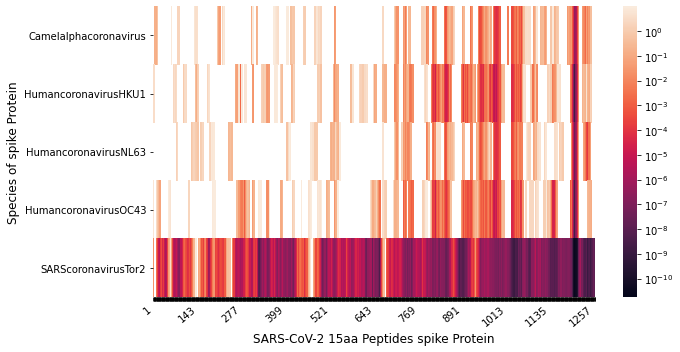

       seq_name_query              
score  surfaceglycoprotein1:15         4.200
       surfaceglycoprotein2:16         5.500
       surfaceglycoprotein263:277      0.465
       surfaceglycoprotein264:278      0.409
       surfaceglycoprotein265:279      0.215
                                       ...  
       surfaceglycoprotein1245:1259    0.140
       surfaceglycoprotein1246:1260    0.150
       surfaceglycoprotein1247:1261    0.190
       surfaceglycoprotein1248:1262    0.935
       surfaceglycoprotein1249:1263    0.720
Length: 375, dtype: float64

['surfaceglycoprotein1204:1218', 2.9599999999999997e-09]
[('surfaceglycoprotein819:833', 2.0700000000000002e-05), ('surfaceglycoprotein849:863', 4.8445e-05), ('surfaceglycoprotein980:994', 1.31e-05), ('surfaceglycoprotein981:995', 7.93e-06), ('surfaceglycoprotein982:996', 7.93e-06), ('surfaceglycoprotein983:997', 7.63e-06), ('surfaceglycoprotein984:998', 4.955e-05), ('surfaceglycoprotein985:999', 2.81e-05), ('surfaceglycoprotein986:1000', 2.42e-05), ('surfaceglycoprotein987:1001', 6.525e-06), ('surfaceglycoprotein988:1002', 8.58e-06), ('surfaceglycoprotein989:1003', 3.955e-05), ('surfaceglycoprotein990:1004', 4.07e-05), ('surfaceglycoprotein1031:1045', 4.855e-05), ('surfaceglycoprotein1032:1046', 4.41e-05), ('surfaceglycoprotein1198:1212', 3.625e-05), ('surfaceglycoprotein1199:1213', 1.1535e-05), ('surfaceglycoprotein1200:1214', 4.875e-07), ('surfaceglycoprotein1201:1215', 1.925e-07), ('surfaceglycoprotein1202:1216', 1.225e-07), ('surfaceglycoprotein1203:1217', 6.539999999999999e-09), 

score  ...                          
seq_name_query        ORF1apolyprotein1:15  ... ORF1apolyprotein4391:4405
species                                     ...                          
Camelalphacoronavirus                  NaN  ...                       NaN
HumancoronavirusHKU1                   NaN  ...                  0.095000
HumancoronavirusOC43                   NaN  ...                  0.061000
SARScoronavirusTor2                0.00001  ...                  0.000009

[4 rows x 4320 columns]

('ORF1apolyprotein1:15', 'ORF1apolyprotein2:16', 'ORF1apolyprotein3:17', 'ORF1apolyprotein4:18', 'ORF1apolyprotein5:19', 'ORF1apolyprotein6:20', 'ORF1apolyprotein7:21', 'ORF1apolyprotein8:22', 'ORF1apolyprotein9:23', 'ORF1apolyprotein10:24', 'ORF1apolyprotein11:25', 'ORF1apolyprotein12:26', 'ORF1apolyprotein13:27', 'ORF1apolyprotein14:28', 'ORF1apolyprotein15:29', 'ORF1apolyprotein16:30', 'ORF1apolyprotein17:31', 'ORF1apolyprotein18:32', 'ORF1apolyprotein19:33', 'ORF1apolyprotein20:34', 'ORF1apolyprotein21:35', 'ORF1apolyprotein22:36', 'ORF1apolyprotein23:37', 'ORF1apolyprotein24:38', 'ORF1apolyprotein25:39', 'ORF1apolyprotein26:40', 'ORF1apolyprotein27:41', 'ORF1apolyprotein28:42', 'ORF1apolyprotein29:43', 'ORF1apolyprotein30:44', 'ORF1apolyprotein31:45', 'ORF1apolyprotein32:46', 'ORF1apolyprotein33:47', 'ORF1apolyprotein34:48', 'ORF1apolyprotein35:49', 'ORF1apolyprotein36:50', 'ORF1apolyprotein37:51', 'ORF1apolyprotein38:52', 'ORF1apolyprotein39:53', 'ORF1apolyprotein40:54', 'ORF1apo

In [ ]:
if __name__ == '__main__':

  # load the SARS-CoV-2 protein sequence
  with open('/content/SARS_CoV_2_proteins_formatted.txt') as f:
    FASTA_file = [line.strip().replace(" ", "") for line in f]
    print('This is your FASTA file: ', FASTA_file)
    COVID_IDs, COVID_seqs = extract_seq(FASTA_file)
    print(COVID_IDs)
    print(COVID_seqs)

  # generate 9-aa and 15-aa fragments of CoV-2 whole proteome
  COVID_pept_name_9, COVID_pept_name_15, COVID_pept_seq_9, COVID_pept_seq_15 = fragment_aa(COVID_IDs, COVID_seqs)

  # generate file with 9-aa peptides of CoV-2
  for i in range(len(COVID_pept_name_9)):
    with open('/content/SARS_CoV_2_proteins_9.txt','a') as f:
      f.write('>' + COVID_pept_name_9[i] + '\n')
      f.write(COVID_pept_seq_9[i] + '\n')

  # generate file with 15-aa peptides of CoV-2
  for i in range(len(COVID_pept_name_15)):
    with open('/content/SARS_CoV_2_proteins_15.txt','a') as f:
      f.write('>' + COVID_pept_name_15[i] + '\n')
      f.write(COVID_pept_seq_15[i] + '\n')

  # generate heatmaps
  # dropped ORF1ab from list as same name as ORF1b
  file_names = ['spike', 'ORF1a', 'membrane', 'envelope', 'nucleocapsid', 'ORF8',
                'ORF6', 'ORF3a', 'ORF7a', 'ORF7b','ORF1b']
  top_hit_list = []
  top_hit_list_threshold = []
  number_of_hits_list = []
  for protein in file_names:
    with open('/content/' + protein + '_blast.txt') as f:
      alignment = [line.strip().replace(" ", "") for line in f]
      print('This is your alignment file: ', alignment[0:100])

    COVID_score, COVID_seq_name_query, COVID_seq_name_db, COVID_species, COVID_name_query_prot, COVID_strain = extract_align(alignment)
    print(COVID_score[:100],COVID_seq_name_db[:100],COVID_seq_name_query[:100])
    COVID_alignment_df = generate_df_pept(COVID_score, COVID_seq_name_query, COVID_seq_name_db, species=COVID_species)
    # generate heatmaps
    generate_heatmaps(COVID_alignment_df, protein)
    # find top hits
    try:
      top_hit, top_hit_threshold, number_of_hits = top_hits(COVID_alignment_df)
      top_hit_list.append(top_hit)
      top_hit_list_threshold.append(top_hit_threshold)
      number_of_hits_list.append([protein, number_of_hits])
    except:
      continue

  # print results from peptide library alignment
  print('Top hits threshold: ', top_hit_list_threshold)
  print('Top hits: ', top_hit_list)
  print('Number of hits: ', number_of_hits_list)

  # To obtain file with sequences based on top hits
  top_hits_sequence(top_hit_list_threshold, COVID_pept_name_15, COVID_pept_seq_15)

  # graph the number of hits
  hit_count_graph(number_of_hits_list)

  # NETMHC hits
  stacked_bars('/content/NET_MHC.tsv')

  # Find sequence homology of peptides across different species
  alignment_name = ['SpikeBeta','ORF1bAlpha','ORF1bBeta']
  peptide_name = ['SpikeBeta','ORF1bAlpha','ORF1bBeta']
  cov_2_pept_all = []
  score_list_all = []
  protein_list = []
  for alignment, peptide in zip(alignment_name, peptide_name):
    # open peptide list
    with open('/content/'+ peptide + '.txt') as f:
      peptide_file = [line.strip() for line in f]

    # open alignment
    with open('/content/' + alignment + '_alignment.txt') as f:
      FASTA_file = [line.strip() for line in f]
      print('This is your FASTA file: ', FASTA_file)
      COVID_IDs, COVID_seqs = extract_seq(FASTA_file)
      print(COVID_IDs)
      print(COVID_seqs)

    # calculate similarity between peptides
    cov_2_pept, score_list = hit_hcov_compare(peptide_file, COVID_seqs)
    cov_2_pept_all.append(cov_2_pept)
    score_list_all.append(score_list)
    name_duplication = []
    for i in range(len(cov_2_pept)*2):
      name_duplication.append(peptide)
    protein_list.append(name_duplication)

  # plot result
  hit_compare_graph(cov_2_pept_all, score_list_all, protein_list)

  # generate heatmaps for the different strains
  file_names = ['OC43_all_spike', 'HKU1_all_spike', '229E_all_spike']
  for protein in file_names:
    with open('/content/' + protein + '_blast.txt') as f:
      alignment = [line.strip().replace(" ", "") for line in f]
      print('This is your alignment file: ', alignment[0:100])

    COVID_score, COVID_seq_name_query, COVID_seq_name_db, COVID_species, COVID_name_query_prot, COVID_strain = extract_align(alignment)
    print(COVID_score[:100],COVID_seq_name_db[:100],COVID_seq_name_query[:100])
    COVID_alignment_df = generate_df_pept(COVID_score, COVID_seq_name_query, COVID_seq_name_db, species=COVID_species, strain=COVID_strain)
    # generate heatmaps
    generate_heatmaps(COVID_alignment_df, protein,strain=COVID_strain)


  # generate bar chart to look at overall identity
  with open('/content/all_HCoV_filtered_file_20.txt') as f:
    alignment = [line.strip().replace(" ", "") for line in f]
    print('This is your alignment file: ', alignment[0:100])

  COVID_score, COVID_seq_name_query, COVID_seq_name_db, COVID_species, COVID_name_query_prot, COVID_strain = extract_align(alignment)
  print(COVID_score[:100],COVID_seq_name_db[:100],COVID_seq_name_query[:100])
  COVID_alignment_df = generate_df_full(COVID_score, COVID_seq_name_query, COVID_seq_name_db, COVID_name_query_prot,species=COVID_species)
  generate_bar(COVID_alignment_df)

  # generate barchart to look at overall coverage
  with open('/content/all_HCoV_blast_query_coverage_tab.txt') as f:
    alignment = [line.strip().replace(" ", "") for line in f]
    print('This is your alignment file: ', alignment[0:100])

  COVID_score, COVID_seq_name_query, COVID_seq_name_db, COVID_species, COVID_name_query_prot, COVID_strain = extract_align(alignment)
  print(COVID_score[:100],COVID_seq_name_db[:100],COVID_seq_name_query[:100])
  COVID_alignment_df = generate_df_full(COVID_score, COVID_seq_name_query, COVID_seq_name_db, COVID_name_query_prot,species=COVID_species)
  generate_bar(COVID_alignment_df, coverage=True)
